# Developing a toy model for exploring uncertainties in the Pearson correlation coefficient

We want a model framework that produces "climate-like" signals with the following properties:
- ability to dial up/down the serial correlation
- ability to dial up/down the number of ensemble members to produce realistic smoothing
- explore the effect of trends

Things to maybe explore:
- How wrong can the "standard" block-bootstrap approach be?
- How do different significance tests perform?
- What is the effect of ensemble averaging?
- Can we usefully quantify the impact of trends which are often not removed?
- What do the results mean for the signal-to-noise paradox?
- How sensitive are other metrics? e.g MSE?

In [1]:
import numpy as np

import xarray as xr

from src import utils

from itertools import cycle

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import Divider, Size

import statsmodels.api as sm
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

import cartopy
import cartopy.crs as ccrs

/datasets/work/oa-dcfp/work/squ027/.conda/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
DATA_DIR = "../../data/"

cartopy.config["pre_existing_data_dir"] = f"{DATA_DIR}/cartopy-data"
cartopy.config["data_dir"] = f"{DATA_DIR}/cartopy-data"

In [4]:
plt.rcParams["figure.figsize"] = (12, 6)

## Load some example real signals to explore and replicate

In [5]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)
can["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.t_ref_global.zarr"
)["t_ref"]
can["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.sst_global.zarr"
)["sst"]

ec = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.precip_global.zarr"
)
ec["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.t_ref_global.zarr"
)["t_ref"]
ec["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.sst_global.zarr"
)["sst"]
ec["slp"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.slp_global.zarr"
)["slp"]

## What do the partial autocorrelation functions look like for these fields?

In [6]:
def acf(ds, dim="time", partial=False, nlags=10):
    """Vectorized Autocorrelation Function for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags, partial):
        if partial:
            return sm.tsa.pacf(data, nlags=nlags)
        else:
            return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(nlags=nlags, partial=partial),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"lag": nlags + 1}),
    ).assign_coords({"lag": range(nlags + 1)})

In [7]:
pacf_can = acf(can, partial=True)
pacf_ec = acf(ec, partial=True)

In [8]:
def plot_pacf_lags(pacf, lags, title=None, figsize=None, vrange=(-1, 1)):

    nrows = len(pacf)
    ncols = len(lags)
    if figsize is None:
        figsize = (5.0 * ncols, 2.5 * nrows)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        nrows,
        ncols,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree(180)),
    )

    bounds = np.linspace(vrange[0], vrange[1], 21)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

    for y, l in enumerate(lags):
        for x, v in enumerate(pacf.keys()):
            ax = axs[x, y]
            p = (
                pacf[v]
                .sel(lag=l)
                .plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vrange[0],
                    vmax=vrange[1],
                    norm=norm,
                    cmap="RdBu_r",
                    add_colorbar=False,
                )
            )
            p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

            ax.set_title(f"{v} | lag {l}")

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(0), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

    if title:
        fig.suptitle(title)

    return fig

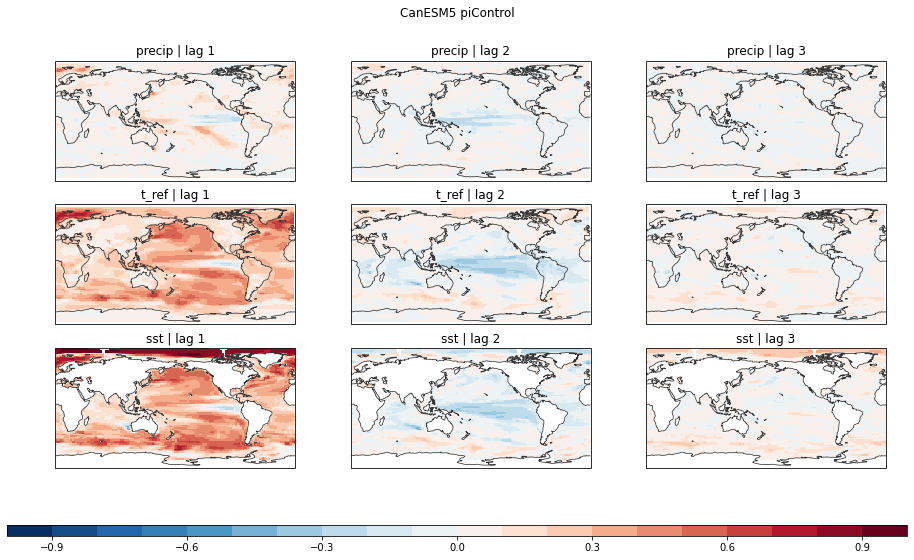

In [9]:
_ = plot_pacf_lags(pacf_can, lags=[1, 2, 3], title="CanESM5 piControl")

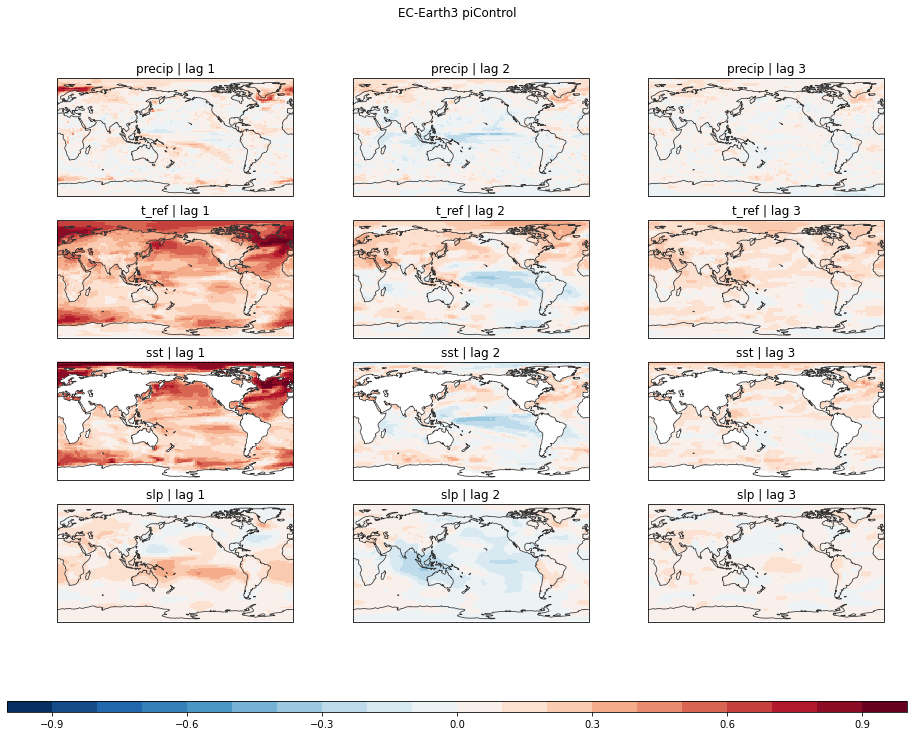

In [10]:
_ = plot_pacf_lags(pacf_ec, lags=[1, 2, 3], title="EC-Earth3 piControl")

## Determine AR(n) coefficients from Yule-Walker equations

In [11]:
def yule_walker(ds, order, dim="time"):
    """Vectorized Autocorrelation Function for xarray objects"""
    from statsmodels.regression.linear_model import yule_walker

    def _yule_walker(data, order):
        rho, sigma = yule_walker(data, order=order, demean=True)
        return np.array((sigma, *rho))

    return xr.apply_ufunc(
        _yule_walker,
        ds,
        kwargs=dict(order=order),
        input_core_dims=[[dim]],
        output_core_dims=[["coeff"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"coeff": order + 1}),
    ).assign_coords({"coeff": range(order + 1)})

In [12]:
order = 2

coeffs_can = yule_walker(can, order=order).compute()
coeffs_ec = yule_walker(ec, order=order).compute()

In [13]:
def plot_coeffs(coeffs, figsize=None):

    ncols = len(coeffs)
    if figsize is None:
        figsize = (5.0 * ncols, 4)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        1,
        ncols,
        sharex=True,
        sharey=True,
    )

    for i, v in enumerate(coeffs.keys()):
        ax = axs[i]
        p = ax.scatter(
            coeffs[v].sel(coeff=1),
            coeffs[v].sel(coeff=2),
            s=10,
            c=coeffs[v].sel(coeff=0),
        )
        ax.set_xlabel(r"$\phi_{1}$")
        ax.set_ylabel(r"$\phi_{2}$")
        ax.set_title(v)
        ax.grid()

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(-0.3), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal", label=r"$\sigma_{\epsilon}$")

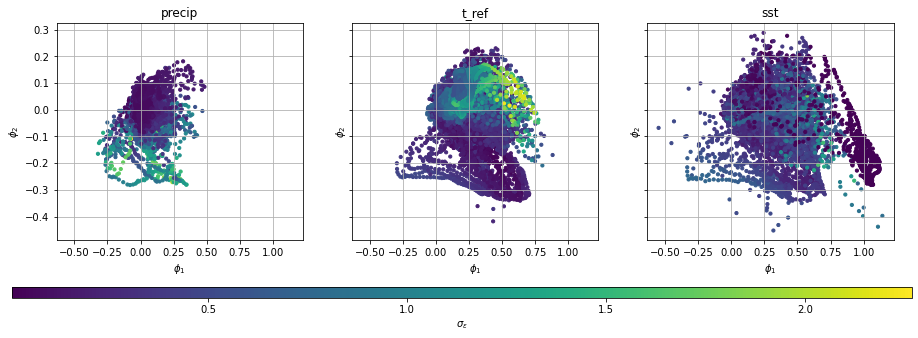

In [14]:
plot_coeffs(coeffs_can)

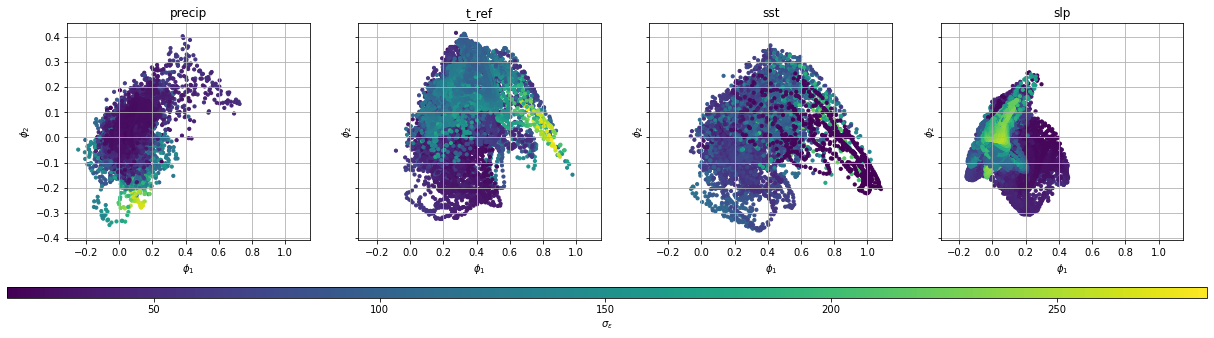

In [15]:
plot_coeffs(coeffs_ec)

## What about coming up with some example cases with similar ACFs to, for example:
- **s1**: highly correlated sst index (e.g. box over Atlantic subpolar gyre - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091307, https://link.springer.com/article/10.1007/s00382-014-2212-7)
- **s2**: nao index (e.g. https://www.nature.com/articles/s41612-019-0071-y)
- **s3**: "independent" precip index (e.g. box over Australia)

In [16]:
def remove_trend(ds, dim="time"):
    if "member" in ds.dims:
        fit = ds.copy().mean("member")
    else:
        fit = ds.copy()

    trend = fit.polyfit(dim=dim, deg=1)
    for v in ds.data_vars:
        fit[v] = xr.polyval(ds[dim], trend[f"{v}_polyfit_coefficients"])
    return ds - fit

## **s1**: Atlantic subpolar gyre

-------------------

### Fit the data

In [17]:
def subpolar_gyre(ds):
    """Return the average over the subpolar gyre region"""
    return utils.extract_lon_lat_box(ds, box=[310, 350, 45, 60], weighted_average=True)

In [18]:
spg = remove_trend(subpolar_gyre(ec))["sst"]

sel = ar_select_order(spg.values, maxlag=10, ic="bic", glob=False, trend="n")
res = sel.model.fit()
s1_params = res.params
s1_ϵ_std = np.sqrt(res.sigma2)

print(f"SPG lags: {sel.ar_lags}")
print(f"SPG coefficients: {s1_params}")
print(f"SPG noise standard dev: {s1_ϵ_std}")

SPG lags: [1, 2, 3, 4]
SPG coefficients: [0.73360845 0.0010884  0.11628575 0.10623847]
SPG noise standard dev: 0.39053488461447083


### Check the pACF

In [19]:
s1_process = ArmaProcess(np.concatenate(([1], -s1_params)))
test = s1_process.generate_sample(nsample=len(spg), scale=s1_ϵ_std)

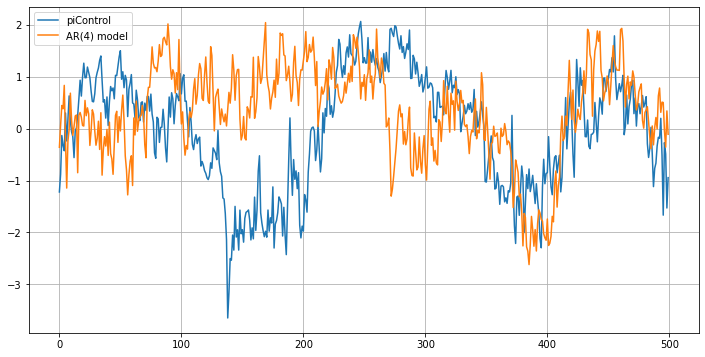

In [20]:
plt.plot(spg, label="piControl")
plt.plot(test, label=f"AR({len(s1_params)}) model")

plt.grid()
_ = plt.legend()

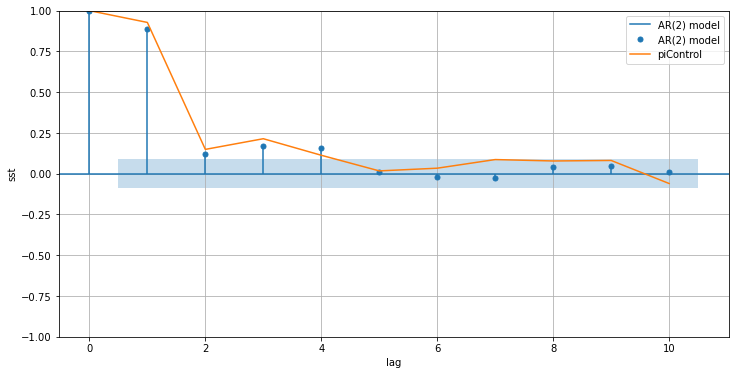

In [21]:
plot_pacf(test, lags=10, method="ywm", label="AR(2) model")
acf(spg, partial=True).plot(label="piControl")

plt.title("")
plt.grid()
_ = plt.legend()

### Generate some samples to construct the null distribution. 
Here we simulate a size-N ensemble by running our model forward from the same state N times

In [22]:
def predict_AR(params, inits, n_steps, n_members=1, scale=None):
    """
    Advance an Autoregressive model forward in time from initial conditions by n_steps

    Parameters
    ----------
    params : numpy array
        The AR(n) model coefficients of the form [param_lag_1, param_lag_2,... param_lag_n]
    inits : numpy array
        Array containing the initial conditions. Can be 1D or 2D. If the latter, the second
        axis should contain different samples of initial conditions.
    n_steps : int
        The number of timesteps to step forward from each initial condition
    scale : float
        The standard deviation of the noise term in the AR(n) model. If None, no noise term
        is included in the predictive model
    """

    def _epsilon(scale, size):
        return np.random.normal(scale=scale, size=size)

    order = len(params)
    params = np.flip(params)

    # Some quick checks
    assert len(inits) >= len(
        params
    ), f"At least {order} initial conditions must be provided for an AR({order}) model"

    if inits.ndim == 1:
        inits = np.expand_dims(inits, axis=-1)

    inits_stacked = sliding_window_view(inits, window_shape=order, axis=0)

    # res = [member, init, sample, lead]
    res = np.empty((n_members, *inits_stacked.shape[:-1], n_steps + order))
    res[:, :, :, :order] = inits_stacked
    for step in range(order, n_steps + order):
        fwd = np.sum(params * res[:, :, :, step - order : step], axis=-1)

        if scale is not None:
            fwd += _epsilon(scale, fwd.shape)
        res[:, :, :, step] = fwd

    # Bundle into xarray DataArray for convenience
    return xr.DataArray(
        res[:, :, :, order:],
        coords={
            "member": range(n_members),
            "init": range(order - 1, len(inits)),
            "sample": range(inits.shape[1]),
            "lead": range(1, n_steps + 1),
        },
    ).squeeze(drop=True)

In [23]:
n_leads = 8
n_members = 50
n_samples = 3

# Test that function works with multiple samples
spg_replicated = np.tile(np.expand_dims(spg, axis=-1), (1, n_samples))

test = predict_AR(
    s1_params, spg_replicated, n_leads, n_members=n_members, ϵ_std=s1_ϵ_std
)
inits = test.init[::n_leads]

sample = 0
ctrl = spg_replicated[:, sample]  # All samples the same

colors = [f"C{i}" for i in range(0, 10)]
colorcycler = cycle(colors)

label = True
for init in inits.values:
    color = next(colorcycler)
    q1 = test.sel(init=init, sample=sample).quantile(0.05, dim="member")
    q2 = test.sel(init=init, sample=sample).quantile(0.95, dim="member")
    plt.fill_between(
        range(init + 1, init + n_leads + 1), q1, q2, color=color, alpha=0.4
    )

    if label:
        l = f"AR({len(s1_params)}) forecast"
    else:
        l = "__nolabel__"

    plt.plot(
        range(init + 1, init + n_leads + 1),
        res.predict(start=init + 1, end=init + n_leads, dynamic=True),
        color=color,
        label=l,
    )

    label = False

plt.plot(ctrl, label="piControl", color="k")
plt.xlim(300, 500)
plt.legend()
plt.grid()

TypeError: predict_AR() got an unexpected keyword argument 'ε_std'

In [819]:
def generate_samples(
    process, scale, n_times, n_samples, n_members=None, rolling_means=None
):
    """
    Generate random samples from an AR process

    Parameters
    ----------
    process : ArmaProcess
        A statsmodels ArmaProcess
    scale : float
        The standard deviation of noise.
    n_times : int
        The number of timesteps to step forward from each initial condition
    n_samples : int
        The standard deviation of the noise term in the AR(n) model. If None, no noise term
        is included in the predictive model
    n_members : int, optional
        The number of ensemble members to generate. N ensemble members are generated from N
        predictions initialised from samples of the provided process. When provided with
        rolling_mean, rolling means of length L are computed by averaging prediction times
        1->L.
    rolling_mean : list, optional
        A list of lengths of rolling means to compute
    """

    if n_members is not None:
        extend = len(process.arcoefs) - 1
    elif rolling_means is None:
        extend = 0
    else:
        extend = max(rolling_means) - 1

    # Generate some AR series
    s = process.generate_sample(
        nsample=(n_times + extend, n_samples), scale=scale, axis=0
    )

    if n_members is None:
        s = xr.DataArray(
            s, coords={"time": range(n_times + extend), "sample": range(n_samples)}
        )
    else:
        n_leads = 1 if rolling_means is None else max(rolling_means)
        s = predict_AR(process.arcoefs, s, n_leads, n_members=n_members, scale=scale)
        s = s.rename({"init": "time"})

    if rolling_means is not None:
        if n_members is not None:
            res = [s.sel(lead=1).assign_coords({"rolling_mean": 1})]
            for av in rolling_means:
                rm = s.sel(lead=slice(1, av)).mean("lead")
                rm = rm.assign_coords({"rolling_mean": av})
                res.append(rm)
        else:
            res = [s.assign_coords({"rolling_mean": 1})]
            for av in rolling_means:
                rm = utils.rolling_mean(
                    s.to_dataset(name="dummy"), window_size=av, dim="time"
                ).dropna("time")["dummy"]
                rm = rm.assign_coords({"rolling_mean": av})
                res.append(rm)

        s = xr.concat(res, dim="rolling_mean", join="inner")
        s = s.assign_coords({"time": range(s.sizes["time"])})

    return s

In [856]:
n_times = 50
n_samples = 100_000
n_members = 10
rolling_means = [2, 4, 8]

s1_obsv = generate_samples(
    s1_process,
    scale=s1_ϵ_std,
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
)

s1_fcst = generate_samples(
    s1_process,
    scale=s1_ϵ_std,
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
)

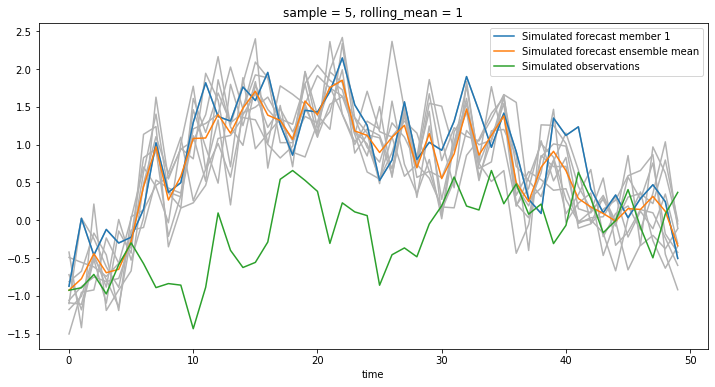

In [857]:
rolling_mean = 1

s1_fcst.sel(sample=5, rolling_mean=rolling_mean).plot.line(
    x="time", color=[0.7, 0.7, 0.7], add_legend=False
)
s1_fcst.sel(sample=5, rolling_mean=rolling_mean).sel(member=1).plot(
    label="Simulated forecast member 1"
)
s1_fcst.sel(sample=5, rolling_mean=rolling_mean).mean("member").plot(
    label="Simulated forecast ensemble mean"
)
s1_obsv.sel(sample=5, rolling_mean=rolling_mean).plot(label="Simulated observations")

_ = plt.legend()

In [858]:
import xskillscore as xs

test = xs.pearson_r(s1_fcst.mean("member"), s1_obsv, dim="time")

In [864]:
def student_t(N):
    """Return Student-t distribution for null correlation"""
    from scipy.stats import beta

    a = N / 2 - 1
    b = N / 2 - 1
    return beta(a, b, loc=-1, scale=2)

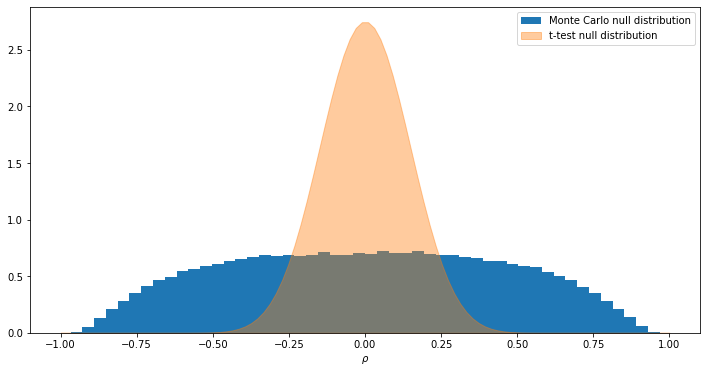

In [870]:
plt.hist(
    test.sel(rolling_mean=8),
    bins=50,
    density=True,
    label="Monte Carlo null distribution",
)

# t-test
t_dist = student_t(50)
x = np.linspace(-1, 1, 100)
plt.fill_between(
    x, t_dist.pdf(x), color="C1", alpha=0.4, label="t-test null distribution"
)

plt.legend()
_ = plt.xlabel(r"$\rho$")

In [696]:
rolling_means = [2, 4, 8]

res = [s1_a.assign_coords({"rolling_mean": 1})]
for av in rolling_means:
    rm = utils.rolling_mean(
        s1_a.to_dataset(name="dummy"), window_size=av, dim="time"
    ).dropna("time")["dummy"]
    rm = rm.assign_coords({"rolling_mean": av})
    res.append(rm)

xr.concat(res, dim="rolling_mean", join="inner")

<xarray.DataArray (rolling_mean: 4, time: 43, sample: 100)>
array([[[ 0.47871377,  1.43133897,  0.63884996, ...,  0.2985172 ,
         -0.09474405, -0.57574017],
        [ 0.47388938,  0.60657821,  1.22212553, ...,  0.24083097,
          0.04727751, -0.18403467],
        [ 0.30186386,  1.01611511,  0.58045445, ...,  0.30136417,
         -0.50735975, -0.57479036],
        ...,
        [ 1.7532621 ,  2.27775747, -1.00171956, ..., -0.71175267,
         -0.4816857 ,  0.95209108],
        [ 1.25627339,  1.90279393, -0.90412574, ..., -0.94041884,
         -0.08073597,  0.84268777],
        [ 1.01072357,  2.75558564, -0.676376  , ..., -1.36940295,
          0.11446216,  0.56106435]],

       [[ 0.53963322,  1.28061386,  0.53636482, ...,  0.3900859 ,
         -0.22368771, -0.34597469],
        [ 0.47630158,  1.01895859,  0.93048774, ...,  0.26967408,
         -0.02373327, -0.37988742],
        [ 0.38787662,  0.81134666,  0.90128999, ...,  0.27109757,
         -0.23004112, -0.37941252],
...
        [ 2.09667903,  2.38304472, -0.56281293, ..., -0.87917415,
         -0.18777379,  0.96617706],
        [ 1.81602976,  2.14264125, -0.77808609, ..., -0.8509896 ,
         -0.29006251,  0.96381108],
        [ 1.43780893,  2.31060849, -0.85398039, ..., -0.98389063,
         -0.2189853 ,  0.78501801]],

       [[ 0.28526992,  0.46127229,  0.25798463, ...,  0.12796238,
         -0.3910579 , -0.31059579],
        [ 0.26954498,  0.51798216,  0.38414766, ...,  0.19727483,
         -0.35369465, -0.32188454],
        [ 0.22748962,  0.72154155,  0.42640874, ...,  0.26333884,
         -0.38395316, -0.32418477],
        ...,
        [ 1.89264626,  2.04742766, -0.42808933, ..., -0.54924681,
         -0.31149513,  0.89859768],
        [ 1.8034208 ,  2.0960024 , -0.5283666 , ..., -0.59418255,
         -0.26959445,  0.90487268],
        [ 1.69884059,  2.21317787, -0.5604456 , ..., -0.77311139,
         -0.17062165,  0.84796207]]])
Coordinates:
  * time          (time) int64 7 8 9 10 11 12 13 14 ... 42 43 44 45 46 47 48 49
  * sample        (sample) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * rolling_mean  (rolling_mean) int64 1 2 4 8

In [689]:
res

[<xarray.DataArray (time: 50, sample: 100)>
 array([[ 0.59968895,  0.15289928,  0.2128213 , ..., -0.31366869,
         -0.25162851, -0.09372463],
        [ 0.6383067 , -0.61236   ,  0.24236583, ..., -0.2271479 ,
         -0.26529164, -0.55638853],
        [-0.1488373 ,  0.28084825, -0.22207633, ..., -0.37814251,
         -0.26116442,  0.15867775],
        ...,
        [ 1.7532621 ,  2.27775747, -1.00171956, ..., -0.71175267,
         -0.4816857 ,  0.95209108],
        [ 1.25627339,  1.90279393, -0.90412574, ..., -0.94041884,
         -0.08073597,  0.84268777],
        [ 1.01072357,  2.75558564, -0.676376  , ..., -1.36940295,
          0.11446216,  0.56106435]])
 Coordinates:
   * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
   * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99,
 <xarray.DataArray 'dummy' (time: 49, sample: 100)>
 array([[ 0.61899782, -0.22973036,  0.22759356, ..., -0.27040829,
         -0.25846008, -0.32505658],


In [ ]:
average = [2, 4, 8]
for av in average:
    hcst[f"{av}-year"] = get_lead(
        utils.rolling_mean(hcst_region, window_size=av, dim="lead"), (av) * 12 + 11
    ).sel(time=slice(*verif_period))
    ctrl[f"{av}-year"] = utils.rolling_mean(
        ctrl_region, window_size=av, dim="time"
    ).dropna("time")

In [659]:
s1_b = predict_AR(s1_params, s1_b, 8, n_members=10, ϵ_std=s1_ϵ_std)

In [660]:
s1_b

<xarray.DataArray (member: 10, init: 47, sample: 100, lead: 8)>
array([[[[-3.70301251e-01, -6.47156961e-01, -7.74011461e-01, ...,
          -2.92541845e-01, -1.00082124e-01,  1.37519706e-01],
         [-5.15073718e-01, -1.07238138e+00, -3.82293569e-01, ...,
          -4.88264231e-01, -6.74556077e-01, -1.18044988e+00],
         [-4.87481248e-01, -4.23705891e-01,  1.51203137e-01, ...,
          -1.01882648e+00, -7.08373366e-02, -6.46783832e-01],
         ...,
         [ 6.22578635e-01,  1.68959172e-01,  1.89886215e-01, ...,
          -9.49168468e-01, -7.49273663e-01, -4.48996963e-01],
         [ 2.48611658e-01,  1.34887327e-01, -5.09058849e-02, ...,
          -5.34082475e-01, -3.12313473e-01, -2.95273485e-01],
         [-5.95123649e-01, -2.37133860e-01,  1.44009704e-02, ...,
           2.73617057e-01,  1.72862126e-01,  7.60655144e-01]],

        [[-4.73659115e-01, -1.06215394e+00, -7.91949411e-01, ...,
          -1.07702873e+00, -1.30005836e+00, -5.90740802e-01],
         [-9.05339973e-01, -1.22384932e+00, -9.83907201e-01, ...,
          -9.07934066e-01, -1.11724711e+00, -8.06612193e-01],
         [-1.08568870e+00, -2.92743762e-01, -5.91050776e-02, ...,
          -2.45955829e-01, -7.99715266e-01, -1.12101018e-01],
...
         [-1.01380780e+00, -7.10834188e-01, -1.19529509e+00, ...,
          -1.46957344e+00, -1.36878879e+00, -9.74473610e-01],
         [-1.30088154e+00, -7.43786334e-01,  2.70614548e-01, ...,
           1.38395033e+00,  8.27494782e-01,  3.86421057e-01],
         [ 2.02066688e+00,  1.84829906e+00,  1.74965886e+00, ...,
           1.58155510e+00,  1.34387270e+00,  1.86834051e+00]],

        [[ 1.47592849e+00,  1.09848389e+00,  1.13626094e+00, ...,
           8.90730621e-01,  1.03373497e+00,  7.74647150e-01],
         [-1.82499579e+00, -1.76366397e+00, -9.41920471e-01, ...,
          -9.97928441e-01, -1.02270276e+00, -9.58756053e-01],
         [-5.76417353e-01, -4.73818970e-01, -3.01885058e-01, ...,
           3.78960699e-01,  4.37881287e-01,  8.07599263e-01],
         ...,
         [-1.56975773e-01, -5.41378330e-01,  2.97284563e-01, ...,
           2.55779393e-01, -3.92704808e-01, -1.39975972e-01],
         [-6.41972659e-01, -9.42804800e-01, -3.62220462e-01, ...,
           4.51344461e-01,  9.35218309e-01,  1.39858584e+00],
         [ 2.10273576e+00,  2.21624484e+00,  2.78346865e+00, ...,
           2.42258848e+00,  1.88287927e+00,  2.01905333e+00]]]])
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * init     (init) int64 3 4 5 6 7 8 9 10 11 12 ... 41 42 43 44 45 46 47 48 49
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * lead     (lead) int64 1 2 3 4 5 6 7 8

### **s2**: NAO index

In [215]:
def north_atlantic_oscillation(ds):
    """Return the nao index used by Smith et al. (2020)"""
    Azores_box = utils.extract_lon_lat_box(
        ds, box=[332, 340, 36, 40], weighted_average=True
    )
    Iceland_box = utils.extract_lon_lat_box(
        ds, box=[335, 344, 63, 70], weighted_average=True
    )
    nao = Azores_box - Iceland_box
    return nao - nao.mean("time")

In [216]:
ec_nao = north_atlantic_oscillation(ec)["slp"]
s2_coeffs = yule_walker(ec_nao, order=2).compute()

In [217]:
ntimes = len(ec_nao)

ar = np.concatenate(([1], -s2_coeffs.sel(coeff=[1, 2])))
s2_process = ArmaProcess(ar)

s2 = s2_process.generate_sample(nsample=ntimes, scale=s2_coeffs.sel(coeff=0).item())

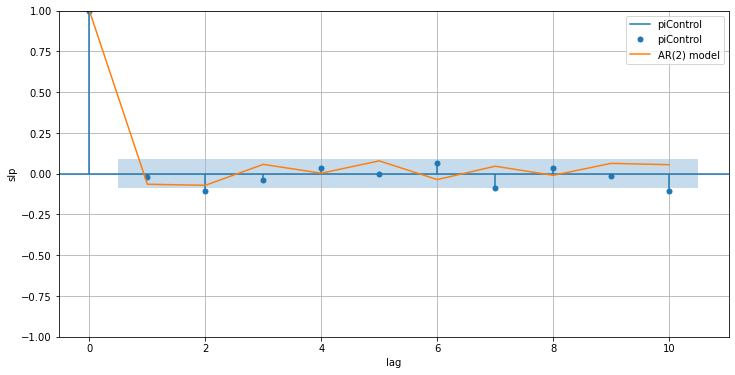

In [218]:
plot_pacf(s2, lags=10, method="ywm", label="piControl")
acf(ec_nao, partial=True).plot(label="AR(2) model")

plt.title("")
plt.grid()
_ = plt.legend()

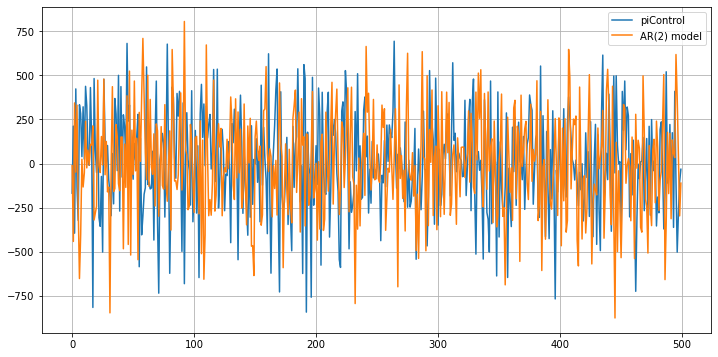

In [219]:
plt.plot(ec_nao, label="piControl")
plt.plot(s2, label="AR(2) model")

plt.grid()
_ = plt.legend()

### Can we build ensemble forecasts with these models?

In [247]:
np.random.standard_normal(50)

array([-1.51745513,  1.92093175, -0.94125319, -1.0254181 , -0.25472485,
        2.19916568, -0.52269948,  0.28218351, -1.76841859, -1.37404369,
       -0.81521254,  2.95730612,  0.36609388,  0.05985637,  2.25451834,
        0.54558068,  0.06496594,  0.01883081,  0.07962581,  1.22004724,
       -1.52973451, -0.5943884 , -0.04607343, -1.04526054, -0.06170846,
        1.7054837 ,  1.31431271,  0.2089277 ,  0.01505166, -1.12590226,
        2.03190828,  0.17505528,  1.35099439, -0.62060778, -1.01546363,
       -0.90103776, -0.79471061,  1.53516759, -0.15305782,  1.57450018,
        0.41350349,  0.21609303, -0.33649965,  0.40340807,  0.32493055,
       -0.40402901, -0.57817948,  0.64798204,  0.62280542,  0.39806471])

In [249]:
init(50)

TypeError: 'numpy.ndarray' object is not callable

In [265]:
def init(size):
    return np.zeros(size)

In [266]:
ntimes = 50
nensemble = 10

ar = np.concatenate(([1], -s1_coeffs.sel(coeff=[1, 2])))
s1_process = ArmaProcess(ar)

s1_obsv = s1_process.generate_sample(
    nsample=ntimes, scale=s1_coeffs.sel(coeff=0).item(), distrvs=init
)

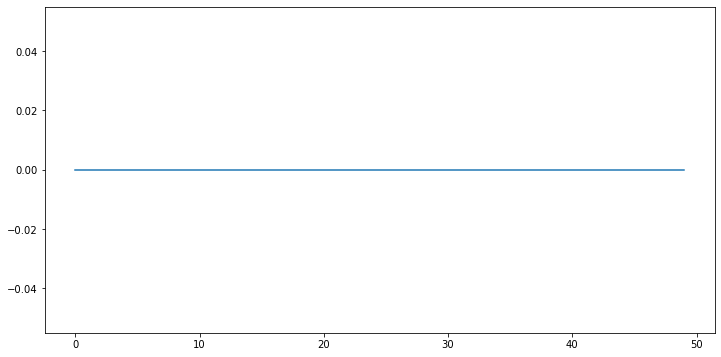

In [267]:
plt.plot(s1_obsv)

In [78]:
from statsmodels.tsa.ar_model import AutoReg

In [149]:
test = can["sst"].sel(lat=60, lon=180, method="nearest").compute().values

In [203]:
f = AutoReg(test, lags=2, trend="n").fit()

In [204]:
f.params

array([0.54150323, 0.01317337])

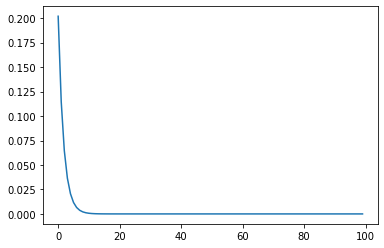

In [205]:
plt.plot(f.forecast(100))

In [206]:
from statsmodels.regression.linear_model import yule_walker

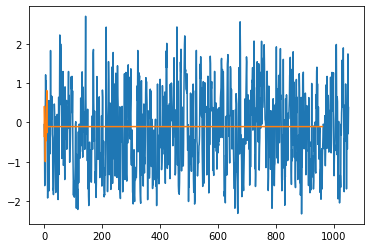

In [181]:
plt.plot(test)

plt.plot(f.predict(start=1040, end=2000, dynamic=1050))

In [ ]:
def AutoReg(ds, dim="time", partial=False, nlags=10):
    """Vectorized Autocorrelation Function for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags, partial):
        if partial:
            return sm.tsa.pacf(data, nlags=nlags)
        else:
            return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(nlags=nlags, partial=partial),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"lag": nlags + 1}),
    ).assign_coords({"lag": range(nlags + 1)})

In [73]:
def init(size):
    
    return arma_process.generate_sample(nsample=size[0])

In [74]:
nsamples = 100
ntimes = 50

ar = np.array([1, -0.8])

arma_process = ArmaProcess(ar)
s = arma_process.generate_sample(nsample=(nsamples, 2), distrvs=init, axis=0)

In [77]:
s.shape

(100,)

In [68]:
s.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [54]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [55]:
import statsmodels.tsa.ar_model

In [ ]:
AutoReg()

In [52]:
np.std(s)

1.2884386827350243

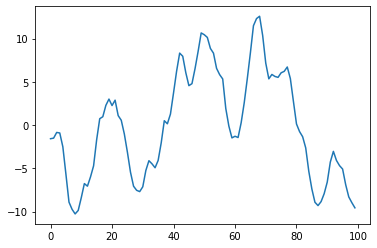

In [75]:
plt.plot(s)

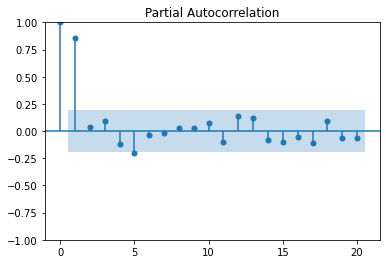

In [45]:
_ = plot_pacf(s, method="ywm")